In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
import time
import torchvision
from torchvision import transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import copy
import matplotlib.pyplot as plt

In [0]:
# Hyperparameter
batch_size = 100
EPOCH = 100


google_drive_fish_classification_path = '/content/drive/My Drive/Colab Notebooks/fish_classification'
local_path = '.'
# the_path = local_path  # pnu pc
the_path = google_drive_fish_classification_path  # colab
dataset_folder = 'Batoidea(ga_oo_lee)'
data_dir = the_path + '/' + dataset_folder
input_size = 224
num_workers = 2
valid_ratio = 0.3
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
channel_stats = dict(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
train_transformation = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(**channel_stats)
])
eval_transformation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(**channel_stats)
])
train_dataset = datasets.ImageFolder(data_dir, train_transformation)
val_dataset = datasets.ImageFolder(data_dir, eval_transformation)

num_samples = len(train_dataset)
indices = list(range(num_samples))
split = int(np.floor(valid_ratio * num_samples))
np.random.seed(123)
np.random.shuffle(indices)
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size, sampler=train_sampler,
                                               num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size, sampler=valid_sampler,
                                            num_workers=num_workers)

dset_loaders = {'train': train_loader,
                'val': valid_loader}
dset_classes = train_dataset.classes
num_class = len(dset_classes)
dset_sizes = {'train': len(train_idx),
                'val': len(valid_idx)}

def exp_lr_scheduler(optimizer, epoch, init_lr=0.01, lr_decay_epoch=10):
    """Decay learning rate by a factor of 0.1 every lr_decay_epoch epochs."""
    lr = init_lr * (0.1**(epoch // lr_decay_epoch))

    if epoch % lr_decay_epoch == 0:
        print('LR is set to {}'.format(lr))

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

    return optimizer

In [0]:
def train_model(model, criterion, optimizer, lr_scheduler, num_epochs=25):
    since = time.time()

    best_model = model
    best_acc = 0.0
    logging_acc = {
        'train': [],
        'val': []
    }
    for epoch in range(num_epochs):
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                optimizer = lr_scheduler(optimizer, epoch)
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dset_loaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss / dset_sizes[phase]
            epoch_acc = running_corrects.item() / dset_sizes[phase]
            logging_acc[phase].append(epoch_acc)
            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            #     phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model = copy.deepcopy(model)
        # print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    plt.plot(range(len(logging_acc['train'])), logging_acc['train'], 'r')
    plt.plot(range(len(logging_acc['val'])), logging_acc['val'], 'b')
    plt.legend(('Train Acc', 'Val Acc'),
               loc='lower right')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()
    return best_model

LR is set to 0.01
LR is set to 0.001
LR is set to 0.00010000000000000002
LR is set to 1.0000000000000003e-05
LR is set to 1.0000000000000002e-06
LR is set to 1.0000000000000002e-07
LR is set to 1.0000000000000004e-08
LR is set to 1.0000000000000005e-09
LR is set to 1.0000000000000006e-10
LR is set to 1.0000000000000004e-11
Training complete in 12m 29s
Best val Acc: 0.815385


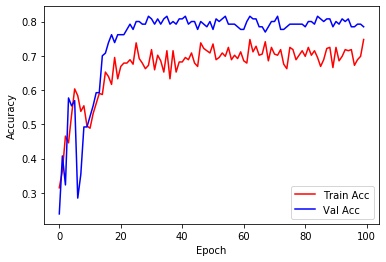

In [0]:
is_fine_tuning = True  # otherwise, its training last layer only
model_conv = torchvision.models.resnet18(pretrained=True)
# model_conv = torchvision.models.resnet50(pretrained=True)
if is_fine_tuning:
    for param in model_conv.parameters():
        param.requires_grad = True
else:
    for param in model_conv.parameters():
        param.requires_grad = False
num_in_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_in_ftrs, num_class)
model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.parameters(), lr=0.01, momentum=0.9)
model_conv = train_model(model_conv, criterion, optimizer_conv,
                            exp_lr_scheduler, num_epochs=EPOCH)
